In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, RNN, Dense, LSTM, Bidirectional, SimpleRNN, BatchNormalization, Conv1D, Input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

In [24]:
# Đọc và xử lý dữ liệu
data_folder = '/kaggle/input/student-performance/data20/data'
all_inputs = []
subject_labels = []
xeploai_labels = []

maxlength = 14

for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_folder, filename)
        df = pd.read_csv(file_path)

        input_data = df.drop(['IDSinhVien', 'TenDot', 'TenDotNumber'], axis=1)

        # Pad or truncate to the last `maxlength`
        if len(input_data) < maxlength:
            # Pad with zeros if less than `maxlength`
            padding = np.zeros((maxlength - len(input_data), input_data.shape[1]))
            input_data = np.vstack((input_data, padding))
        else:
            # Truncate to the last `maxlength`
            input_data = input_data[-maxlength:]

        # Extract labels: predict next semester's MaMonHoc and xeploai
        subject_label = df.iloc[-1]['MaMonHoc']  # Classification target (MaMonHoc)
        xeploai_label = df.iloc[-1]['xeploai']  # Classification target (xeploai)

        # Append the input and label data
        all_inputs.append(input_data)
        subject_labels.append(subject_label)
        xeploai_labels.append(xeploai_label)

X = np.array(all_inputs)
subject_labels = np.array(subject_labels)
xeploai_labels = np.array(xeploai_labels)

# Reshape dữ liệu để phù hợp với yêu cầu của LSTM
timesteps = maxlength
num_features = X.shape[2]

# Scale dữ liệu
scaler = StandardScaler()
X_reshaped = X.reshape(-1, num_features)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape[0], timesteps, num_features)

In [25]:
# Khởi tạo LabelEncoder
subject_label_encoder = LabelEncoder()
xeploai_label_encoder = LabelEncoder()

# Ánh xạ tất cả các giá trị labels từ toàn bộ dữ liệu
subject_labels_encoded = subject_label_encoder.fit_transform(subject_labels)
xeploai_labels_encoded = xeploai_label_encoder.fit_transform(xeploai_labels)

# Kiểm tra số lớp
num_classes_subject = len(subject_label_encoder.classes_)
num_classes_xeploai = len(xeploai_label_encoder.classes_)

print("Number of classes in subject:", num_classes_subject)
print("Number of classes in xeploai:", num_classes_xeploai)

Number of classes in subject: 31
Number of classes in xeploai: 4


# Split the dataset into training and testing sets

In [26]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, subject_train, subject_test, xeploai_train, xeploai_test = train_test_split(
    X_scaled, subject_labels_encoded, xeploai_labels_encoded, test_size=0.2, random_state=42
)

In [27]:
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of subject_train:', subject_train.shape)
print('Shape of subject_test:', subject_test.shape)
print('Shape of xeploai_train:', xeploai_train.shape)
print('Shape of xeploai_test:', xeploai_test.shape)

Shape of X_train: (14011, 14, 6)
Shape of X_test: (3503, 14, 6)
Shape of subject_train: (14011,)
Shape of subject_test: (3503,)
Shape of xeploai_train: (14011,)
Shape of xeploai_test: (3503,)


# Tạo lớp Callback

In [28]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, delta=0.001, max_acc = 0.9):
        super(myCallback, self).__init__()
        self.patience = patience
        self.delta = delta
        self.wait = 0
        self.best_val_acc = -float('inf')
        self.max_acc = max_acc

    def on_epoch_end(self, epoch, logs={}):
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is None:
            return

        if current_val_acc > self.best_val_acc + self.delta:
            self.best_val_acc = current_val_acc
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print("\nTraining stopped as val_accuracy did not improve for {} epochs.".format(self.patience))
            
        if logs.get('val_accuracy') >=  self.max_acc and logs.get('accuracy') >=  self.max_acc:
            self.model.stop_training = True

# Các hàm đánh giá

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, normalize=True, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def plot_model_evaluation(history, metrics=[['accuracy', 'val_accuracy'], ['loss', 'val_loss']]):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Setup figure with 2 subplots

    for i, metric in enumerate(metrics):
        axs[i].plot(history.history[metric[0]], 'g-o', label=f'Training {metric[0]}', alpha=0.5)
        axs[i].plot(history.history[metric[1]], 'b-+', label=f'Validation {metric[1]}', alpha=0.5)
        axs[i].set_title(f'Model {metric[0].capitalize()}')
        axs[i].set_ylabel(metric[0].capitalize())
        axs[i].set_xlabel('Epoch')
        axs[i].legend(loc='upper left')

    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()

# LSTM

In [30]:
class LSTMCell(tf.keras.layers.Layer):
    def __init__(self, lstm_units, input_dim):
        super(LSTMCell, self).__init__()
        self.lstm_units = lstm_units
        self.state_size = [lstm_units, lstm_units]

        # Trọng số cho từng cổng
        self.W_f = self.add_weight(shape=(input_dim + lstm_units, lstm_units), initializer='glorot_uniform', trainable=True)
        self.b_f = self.add_weight(shape=(lstm_units,), initializer='zeros', trainable=True)

        self.W_i = self.add_weight(shape=(input_dim + lstm_units, lstm_units), initializer='glorot_uniform', trainable=True)
        self.b_i = self.add_weight(shape=(lstm_units,), initializer='zeros', trainable=True)

        self.W_c = self.add_weight(shape=(input_dim + lstm_units, lstm_units), initializer='glorot_uniform', trainable=True)
        self.b_c = self.add_weight(shape=(lstm_units,), initializer='zeros', trainable=True)

        self.W_o = self.add_weight(shape=(input_dim + lstm_units, lstm_units), initializer='glorot_uniform', trainable=True)
        self.b_o = self.add_weight(shape=(lstm_units,), initializer='zeros', trainable=True)

    def call(self, inputs, states):
        h_prev, c_prev = states

        # Ghép inputs và trạng thái ẩn trước đó
        x_h = tf.concat([inputs, h_prev], axis=-1)

        # Tính toán các cổng
        f = tf.sigmoid(tf.matmul(x_h, self.W_f) + self.b_f)
        i = tf.sigmoid(tf.matmul(x_h, self.W_i) + self.b_i)
        c_ = tf.tanh(tf.matmul(x_h, self.W_c) + self.b_c)
        c = f * c_prev + i * c_
        o = tf.sigmoid(tf.matmul(x_h, self.W_o) + self.b_o)
        h = o * tf.tanh(c)

        return h, [h, c]
lstm_subject_model = Sequential()
lstm_subject_model.add(RNN(LSTMCell(128, X_train.shape[2]), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_subject_model.add(RNN(LSTMCell(64, 128), return_sequences=False))  # input_dim cho lớp này là 128 từ lớp trước
lstm_subject_model.add(Dense(num_classes_subject, activation='softmax'))
lstm_subject_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mô hình lstm_xeploai_model
lstm_xeploai_model = Sequential()
lstm_xeploai_model.add(RNN(LSTMCell(128, X_train.shape[2]), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_xeploai_model.add(RNN(LSTMCell(64, 128), return_sequences=False))  # input_dim cho lớp này là 128 từ lớp trước
lstm_xeploai_model.add(Dense(num_classes_subject, activation='softmax'))
lstm_xeploai_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
lstm_subject_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_4 (RNN)                     │ (None, 14, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_5 (RNN)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,543 (470.87 KB)

 Trainable params: 120,543 (470.87 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
lstm_xeploai_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_6 (RNN)                     │ (None, 14, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_7 (RNN)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,543 (470.87 KB)

 Trainable params: 120,543 (470.87 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
callback = myCallback()
lstm_subject_history = lstm_subject_model.fit(
    X_train, 
    subject_train, 
    batch_size=256, 
    epochs=300, 
    validation_data=(X_test, subject_test), 
    callbacks=[callback]
)

Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.1399 - loss: 3.0531 - val_accuracy: 0.1542 - val_loss: 2.5771
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.1854 - loss: 2.5146 - val_accuracy: 0.3186 - val_loss: 2.0273
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.3532 - loss: 1.8936 - val_accuracy: 0.4356 - val_loss: 1.5743
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.4722 - loss: 1.5186 - val_accuracy: 0.5829 - val_loss: 1.2347
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6205 - loss: 1.1213 - val_accuracy: 0.7108 - val_loss: 0.8559
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7010 - loss: 0.8212 - val_accuracy: 0.7308 - val_loss: 0.6873
Epoch 7/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.7402 - loss: 0.6557 - val_accuracy: 0.7588 - val_loss: 0.6256
Epoch 8/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7473 - loss: 0.6496 - val_accuracy: 0.

In [34]:
callback = myCallback()
lstm_xeploai_history = lstm_xeploai_model.fit(
    X_train, 
    xeploai_train, 
    batch_size=256, 
    epochs=300, 
    validation_data=(X_test, xeploai_test), 
    callbacks=[callback]
)

Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.3050 - loss: 2.4342 - val_accuracy: 0.4256 - val_loss: 1.2732
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4567 - loss: 1.2248 - val_accuracy: 0.7228 - val_loss: 0.7126
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8285 - loss: 0.5609 - val_accuracy: 0.9620 - val_loss: 0.1761
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9930 - loss: 0.1044 - val_accuracy: 1.0000 - val_loss: 0.0269


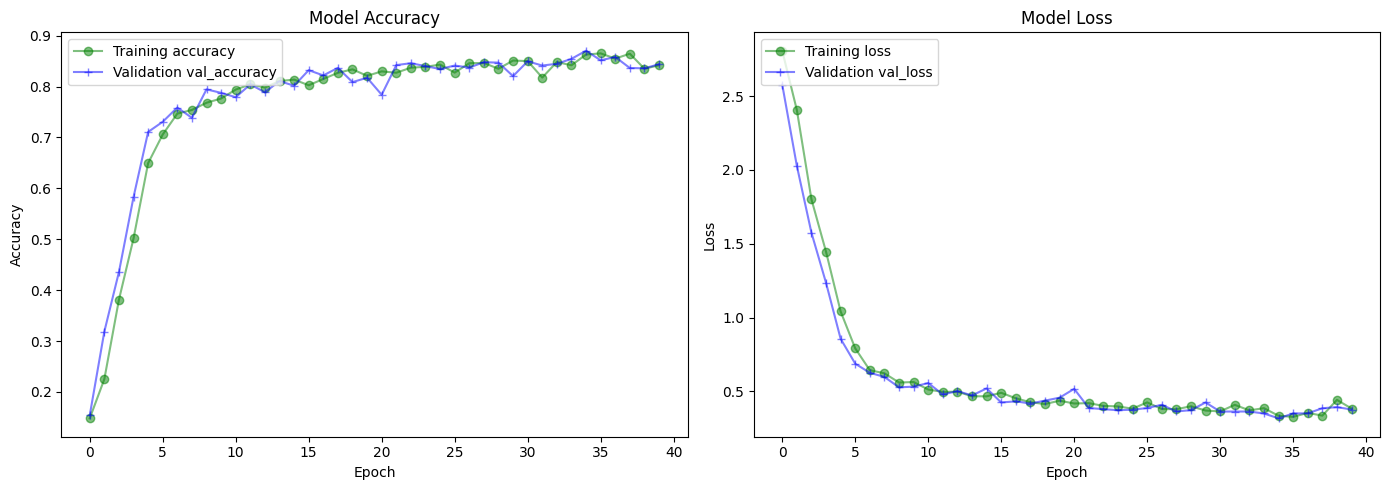

In [35]:
plot_model_evaluation(lstm_subject_history)

In [36]:
subject_test_lstm = np.argmax(lstm_subject_model.predict(X_test), axis=1)
subject_test_ = np.argmax(subject_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


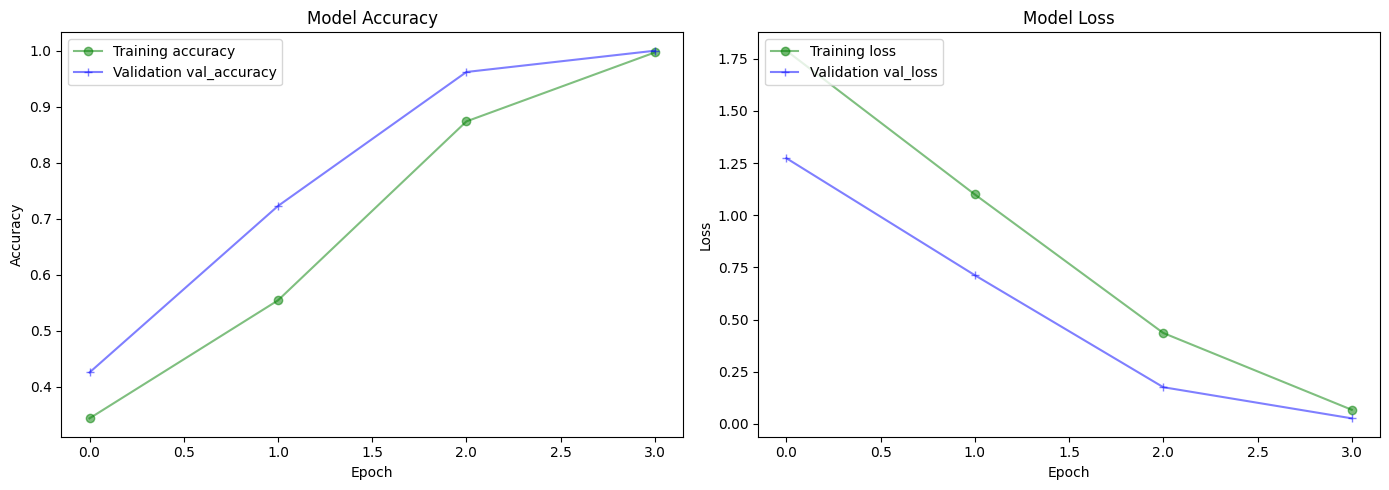

In [37]:
plot_model_evaluation(lstm_xeploai_history)

In [38]:
xeploai_test_lstm = np.argmax(lstm_xeploai_model.predict(X_test), axis=1)
xeploai_test_ = np.argmax(xeploai_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [39]:
subject_model_path = '/kaggle/working/lstm_subject_model.h5'
lstm_subject_model.save(subject_model_path)
xeploai_model_path = '/kaggle/working/lstm_xeploai_model.h5'
lstm_xeploai_model.save(xeploai_model_path)

In [40]:
def predict(file_path):
    df = pd.read_csv(file_path)
    input_data = df.drop(['IDSinhVien', 'TenDot', 'TenDotNumber'], axis=1)
    padding = np.zeros((maxlength - len(input_data), input_data.shape[1]))
    input_data = np.vstack((input_data, padding))
    input_data = input_data[-maxlength:]
    X = np.array([input_data])
    X_reshaped = X.reshape(-1, num_features)
    X_scaled = scaler.transform(X_reshaped)
    X_scaled = X_scaled.reshape(X.shape[0], timesteps, num_features)
    subject_label = df.iloc[-1]['MaMonHoc']
    xeploai_label = df.iloc[-1]['xeploai']
    subject_label_encoded = subject_label_encoder.transform([subject_label])
    xeploai_label_encoded = xeploai_label_encoder.transform([xeploai_label])
    subject_pred = lstm_subject_model.predict(X_scaled)
    xeploai_pred = lstm_xeploai_model.predict(X_scaled)
    subject_pred = np.argmax(subject_pred)
    xeploai_pred = np.argmax(xeploai_pred)
    subject_pred = subject_label_encoder.inverse_transform([subject_pred])
    xeploai_pred = xeploai_label_encoder.inverse_transform([xeploai_pred])
#     print('Predicted subject:', subject_pred[0])
#     print('Predicted xeploai:', xeploai_pred[0])
#     print('Actual subject:', subject_label)
#     print('Actual xeploai:', xeploai_label)
    return (subject_pred[0], xeploai_pred[0])

In [41]:
data_folder = '/kaggle/input/student-performance/data20/test'
all_inputs = []
subject_test = []
xeploai_test = []
subject_predict = []
xeploai_predict = []
maxlength = 14

for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_folder, filename)
        df = pd.read_csv(file_path)
        Y_sj = df.iloc[-1, 3]
        Y_xl = df.iloc[-1, -1]
        xeploai_test.append(Y_xl)
        subject_test.append(Y_sj)
        sj,xl = predict(file_path)
        xeploai_predict.append(xl)
        subject_predict.append(sj)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [42]:
acc_xl = 0
for i in range(len(xeploai_test)):
    if xeploai_test[i] == xeploai_predict[i]:
        acc_xl = acc_xl+1
acc_xl = acc_xl / len(xeploai_test)
acc_xl

1.0

In [43]:
acc_sj = 0
for i in range(len(subject_test)):
    if subject_test[i] == subject_predict[i]:
        acc_sj = acc_sj+1
acc_sj = acc_sj / len(xeploai_test)
acc_sj

0.8181818181818182